# Fun project creating regressor for Berlin flat price using data from 2019

## steps to approach the project

1. Preprosess data i.e. PCA finding the make-sense features, 
2. EDA the cleansed dataset
3. Modeling
4. Model evaluation
5. Deploy model using FastAPI

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

## step 1: Pre-process data

In [2]:
df_org = pd.read_csv('berlin-houses.csv')
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1038 non-null   int64  
 1   lat                       1038 non-null   float64
 2   lon                       1038 non-null   float64
 3   cold_price                1038 non-null   float64
 4   currency                  1038 non-null   object 
 5   short_listed              1038 non-null   bool   
 6   postcode_id               1038 non-null   int64  
 7   balcony                   1038 non-null   bool   
 8   builtin_kitchen           1038 non-null   bool   
 9   created_date              1001 non-null   object 
 10  energy_certificate        1038 non-null   bool   
 11  has_new_flag              1038 non-null   bool   
 12  living_space              1018 non-null   float64
 13  new_home_builder          1038 non-null   bool   
 14  number_r

## Dataset

The dataset used for the analysis can be found in the file `berlin-houses.csv`

The variables of this dataset are:

- `id` - id of listing
- `lat` - latitude of the listing
- `lon` - longitude of the listing
- `cold_price` - price of the listing before heating and upkeep costs
- `warm_price` - price of the listing after heating and upkeep costs
- `currency` - currency of the listing prices
- `short_listed` - if a given listing has short listed candidates
- `postcode_id` - post code of the listing
- `balcony` - if a listing has a balcony
- `builtin_kitchen` - if a listing has a built-in kitchen
- `created_date` - date the listing was created
- `modified_date` - date the listing was modified
- `published_date` - date the listing was published
- `energy_certificate` - if a listing has an energy certificate
- `has_new_flag` - if a listing is a new build or has been renovated recently.
- `living_space` - the living area in squared meters (m2)
- `new_home_builder` - if a listing has been built by new building company
- `number_rooms` - total number of rooms in listing
- `private_offer` - if a listing is pusblished by private owner
- `address` - address of the listing
- `link` - link to listing page
- `quarter` - district where listing is located
- `garden` - if a listing has a garden
- `listing_type` - listing size category
- `localhost_date` - date when listing data was saved into database
- `no_longer_available` - if listing is no longer available in website
- `no_longer_available_date` - date when listing was no longer available on the website

In [3]:
all_feats = df_org.columns.values
useful_feats = df_org.drop(columns=['id','currency','cold_price','currency','short_listed',
                                'created_date','published_date',
                                'modified_date','address','link',
                                'listing_type','localhost_date','no_longer_available',
                                'no_longer_available_date','quarter']).columns.values
num_feats = ['lat', 'lon','number_rooms','living_space','warm_price']
cat_feats = df_org[useful_feats].drop(num_feats,axis=1).columns.values

In [4]:
x = ['id','currency','cold_price','currency','short_listed',
                                'created_date','published_date',
                                'modified_date','address','link',
                                'listing_type','localhost_date','no_longer_available',
                                'no_longer_available_date','quarter']

### Reason for dropping below columns
- `cold_price` col is dropped as it is redundent to `warm_price`
- `quarter` col is dropped as `lat`, `long`, and `PLZ` are chosen as location information group
- `address` col is dropped as it is redundent to location information group

**Below features are dropped as they are rather metadata of the flat and don't add any value to the model trainning**
- `id` 
- `currency` 
- `currency` 
- `short_listed` 
- `created_date` 
- `published_date` 
- `modified_date` 
- `link` 
- `listing_type` 
- `localhost_date` 
- `no_longer_available` 
- `no_longer_available_date` 

In [5]:
df = df_org[useful_feats].dropna()
df['postcode_id'] = df['postcode_id'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1018 entries, 1 to 1037
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   lat                 1018 non-null   float64 
 1   lon                 1018 non-null   float64 
 2   postcode_id         1018 non-null   category
 3   balcony             1018 non-null   bool    
 4   builtin_kitchen     1018 non-null   bool    
 5   energy_certificate  1018 non-null   bool    
 6   has_new_flag        1018 non-null   bool    
 7   living_space        1018 non-null   float64 
 8   new_home_builder    1018 non-null   bool    
 9   number_rooms        1018 non-null   float64 
 10  private_offer       1018 non-null   bool    
 11  warm_price          1018 non-null   float64 
 12  garden              1018 non-null   bool    
dtypes: bool(7), category(1), float64(5)
memory usage: 57.1 KB


In [6]:
df.sample(3)

,lat,lon,postcode_id,balcony,builtin_kitchen,energy_certificate,has_new_flag,living_space,new_home_builder,number_rooms,private_offer,warm_price,garden
104,52.53007,13.42640,10405,True,False,False,True,40.83,False,2.0,False,755.36,False
606,52.51030,13.39771,10117,True,True,False,True,47.32,False,2.0,True,895.00,False
389,52.52285,13.45115,10249,False,True,True,True,55.00,False,2.0,False,1010.00,False


In [7]:
df[num_feats].head(2)

,lat,lon,number_rooms,living_space,warm_price
1,52.46982,13.43096,2.0,59.00,630.98
2,52.54727,13.39899,2.0,51.98,952.47


In [8]:
df[cat_feats].head(2)

,postcode_id,balcony,builtin_kitchen,energy_certificate,has_new_flag,new_home_builder,private_offer,garden
1,12051,True,False,False,False,False,False,False
2,13355,True,True,True,False,False,False,False


In [9]:
df_analysis = df[useful_feats]

In [10]:
df_analysis.sample(3)

,lat,lon,postcode_id,balcony,builtin_kitchen,energy_certificate,has_new_flag,living_space,new_home_builder,number_rooms,private_offer,warm_price,garden
851,52.50495,13.40356,10969,True,False,True,True,53.40,False,2.0,False,876.51,False
400,52.52935,13.39791,10119,False,False,True,True,101.26,False,4.0,False,853.17,False
327,52.48290,13.43422,12043,True,True,True,True,54.40,False,2.0,False,899.00,False


In [11]:
X = df_analysis.drop(columns=['warm_price'])
y = df_analysis['warm_price']
SEED = 42

# Create a PCA model with 10 components
pca = PCA(n_components=10)

# Fit the model to the data and transform the data
X_transformed = pca.fit_transform(X)

# Get the explained variance ratio of each component
explained_variance = pca.explained_variance_ratio_

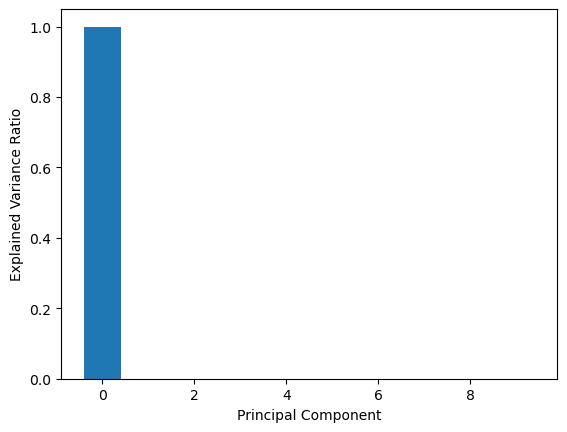

In [12]:
# create a bar chart
plt.bar(range(len(explained_variance)), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

# show the plot
plt.show()

Clearly PCA doesn't help. I will then use RandomForest to determine feature importances

In [13]:
from sklearn.ensemble import RandomForestRegressor

Text(0.5, 1.0, 'Feature Importance in RF Regression Model')

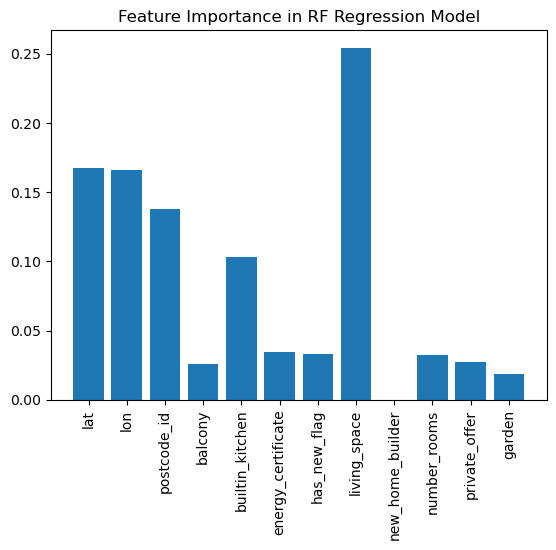

In [14]:
rfr = RandomForestRegressor(max_depth=16, 
                           n_estimators=700, 
                           max_features='log2', 
                           random_state=SEED) 

rfr.fit(X,y)

importance = rfr.feature_importances_

f_importance = {}
for i in range(len(df_analysis.drop(columns=['warm_price']).columns)):
     f_importance[df_analysis.drop(columns=['warm_price']).columns[i]] = importance[i]
        
plt.bar(f_importance.keys(),f_importance.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in RF Regression Model')

From RandomForestRegressor feature importance, living space takes highest importance, and followed by location information group, and then if the flat has EBK or not.

## step 2: EDA

In [15]:
import seaborn as sns

In [16]:
df[num_feats]

,lat,lon,number_rooms,living_space,warm_price
1,52.46982,13.43096,2.0,59.00,630.98
2,52.54727,13.39899,2.0,51.98,952.47
3,52.51210,13.46197,2.0,80.00,1139.00
4,52.50508,13.38592,2.0,64.63,735.51
5,52.50646,13.47007,4.0,137.84,1364.62
...,...,...,...,...,...
1033,52.50098,13.39864,2.0,59.46,959.92
1034,52.48270,13.43129,2.0,52.39,904.00
1035,52.48915,13.42391,2.0,70.00,1225.00
1036,52.47846,13.44806,2.0,57.20,1043.00


<AxesSubplot: >

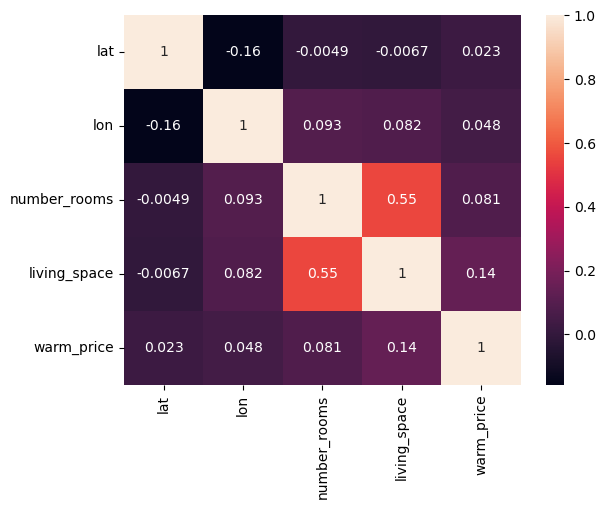

In [17]:
sns.heatmap(df[num_feats].corr(),annot=True)

From numerical features perspective, belows are spotted:
- number of rooms correlates with living space positively
- The flat price has mild correlations with all numerical features

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 [Text(0, 0, '10099'),
  Text(1, 0, '10115'),
  Text(2, 0, '10117'),
  Text(3, 0, '10119'),
  Text(4, 0, '10178'),
  Text(5, 0, '10179'),
  Text(6, 0, '10235'),
  Text(7, 0, '10243'),
  Text(8, 0, '10245'),
  Text(9, 0, '10247'),
  Text(10, 0, '10248'),
  Text(11, 0, '10249'),
  Text(12, 0, '10317'),
  Text(13, 0, '10365'),
  Text(14, 0, '10367'),
  Text(15, 0, '10405'),
  Text(16, 0, '10407'),
  Text(17, 0, '10435'),
  Text(18, 0, '10437'),
  Text(19, 0, '10439'),
  Text(20, 0, '10707'),
  Text(21, 0, '10777'),
  Text(22, 0, '10779'),
  Text(23, 0, '10781'),
  Text(24, 0, '10783'),
  Text(25, 0, '10785'),
  Text(26, 0, '10787'),
  Text(27, 0, '10823'),
  Text(28, 0, '10825'),
  Text(29, 0, '10827'),
  Text(30, 0, '10961'),
  Text(31, 0, '10963'),
  Text(32, 0, '10965'),


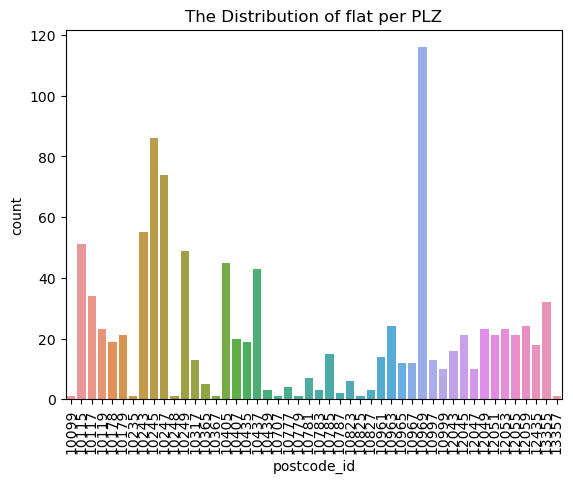

In [18]:
sns.countplot(data=df_analysis,x='postcode_id').set(title='The Distribution of flat per PLZ')
plt.xticks(rotation=90)

In [19]:
df[cat_feats].columns[1:]

Index(['balcony', 'builtin_kitchen', 'energy_certificate', 'has_new_flag',
       'new_home_builder', 'private_offer', 'garden'],
      dtype='object')

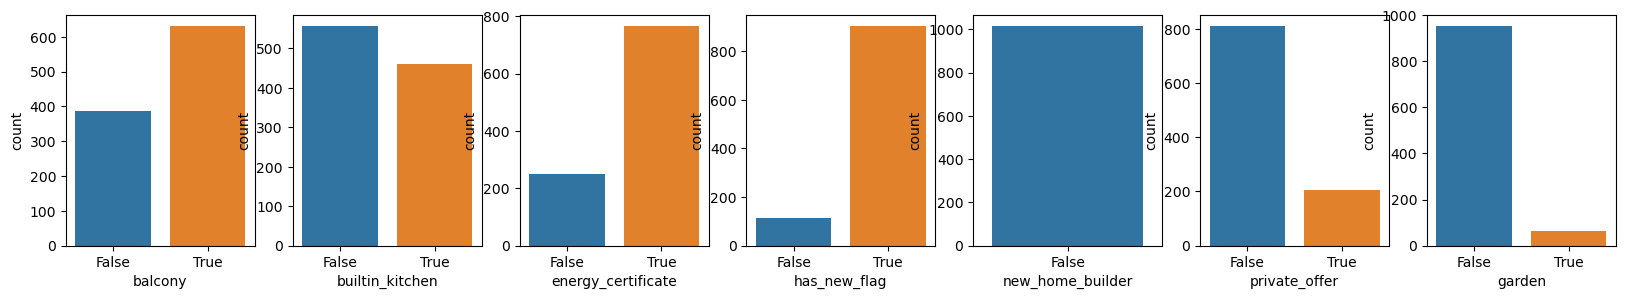

In [20]:
fig, axes = plt.subplots(1,7,figsize=(20,3))
# sns.countplot(data=df_analysis,x='balcony', ax=axes[0])
# sns.countplot(data=df_analysis,x='builtin_kitchen', ax=axes[1])
# sns.countplot(data=df_analysis,x='energy_certificate', ax=axes[2])

for i, col in enumerate(df[cat_feats].columns[1:]):
    sns.countplot(data=df_analysis,x=col,ax=axes[i])

We can even drop `new_home_builder` feature since all values are identical.

In [21]:
final_features = df_analysis.drop(columns=['new_home_builder','warm_price']).columns.values
final_features

array(['lat', 'lon', 'postcode_id', 'balcony', 'builtin_kitchen',
       'energy_certificate', 'has_new_flag', 'living_space',
       'number_rooms', 'private_offer', 'garden'], dtype=object)

## step 3: Modeling

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [23]:
X = df[final_features]
y = df['warm_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [24]:
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)

## step 4: Model evaluation

In [25]:
r2 = r2_score(y_test,y_pred)
RMSE = mean_squared_error(y_test,y_pred,squared=False)
print(f"Model r2: {r2}")
print(f"Model RMSE: {RMSE}")

Model r2: 0.35247594665897075
Model RMSE: 187.54594547870906


In [26]:
X_test[:2]

,lat,lon,postcode_id,balcony,builtin_kitchen,energy_certificate,has_new_flag,living_space,number_rooms,private_offer,garden
545,52.52372,13.40352,10178,True,True,False,True,76.0,2.0,True,False
934,52.50370,13.38351,10963,False,False,True,True,53.3,2.0,False,False


In [27]:
rfr.predict(X_test[:2])

array([1073.17953005,  761.57484132])

## step 4.1: Retry with other features

In [49]:
X = df[['postcode_id','builtin_kitchen','living_space']]
y = df['warm_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
r2 = r2_score(y_test,y_pred)
RMSE = mean_squared_error(y_test,y_pred,squared=False)
print(f"Model r2: {r2}")
print(f"Model RMSE: {RMSE}")

Model r2: 0.22463866678626976
Model RMSE: 205.2257239966424


Looks like the feature trim down doesn't yield the desired metrics.

In [50]:
X_test[:2]

,postcode_id,builtin_kitchen,living_space
545,10178,True,76.0
934,10963,False,53.3


In [51]:
rfr.predict(X_test[:2])

array([1083.42759517,  794.75869924])

## step 4.2: Retry with other model - distillation from DecisionTreeModel

In [31]:
from sklearn.tree import DecisionTreeRegressor

In [32]:
X = df[final_features]
y = df['warm_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

rfr = RandomForestRegressor(max_depth=16, 
                           n_estimators=700, 
                           max_features='log2', 
                           random_state=SEED) 

dtr = DecisionTreeRegressor(max_depth=10, 
                           max_features='log2',
                           min_samples_leaf=1,
                           random_state=SEED,)

distilled_y = dtr.fit(X_train,y_train).predict(X_train)
rfr.fit(X_train, distilled_y)
r2 = r2_score(y_test,y_pred)
RMSE = mean_squared_error(y_test,y_pred,squared=False)
print(f"Model r2: {r2}")
print(f"Model RMSE: {RMSE}")

Model r2: 0.3188925452255137
Model RMSE: 192.34794186402164


Looks like teacher-student model again doesn't yield the desired metrics.

In [33]:
X_test[:2]

,lat,lon,postcode_id,balcony,builtin_kitchen,energy_certificate,has_new_flag,living_space,number_rooms,private_offer,garden
545,52.52372,13.40352,10178,True,True,False,True,76.0,2.0,True,False
934,52.50370,13.38351,10963,False,False,True,True,53.3,2.0,False,False


In [34]:
rfr.predict(X_test[:2])

array([1078.71576488,  836.69559924])

## step 4.3: Retry with other model - DNN - still on the to do list

In [35]:
# from keras.models import Sequential
# from keras.layers import Dense

## step 5: Serve the model using FastAPI - done in main.py

At the end, I decided to go with easy model with minimal 3 features i.e. PLZ, flat size, and if flat has EKB or not, so that my FastAPI experiment wouldn't be too troublesome.

In [55]:
import pickle

X = df[['postcode_id','builtin_kitchen','living_space']]
y = df['warm_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
rfr.fit(X_train,y_train)

filename = './app/model.pickle'
pickle.dump(rfr, open(filename, 'wb'))

## step 6: Deploy model to Heroku - still on the to do list